# Carte abstraite

Par abstrait on veut dire ne reprenant pas la géographie électorale.
L'idée est de générer une population électorale et un découpage en circonscriptions qui ne soit pas liés à la géographie actuelle, mais qui en ait les caractéristiques statistiques (pour la population, répartition des opinions politiques identiques au 1er tour de 2017, pour les circonscriptions, distribution des tailles et des biais dans les représentations des opinions politiques calqués sur ce même premier tour).
Le nombre de circonscription devient un paramètre du modèle qu'on peut ajuster sans se soucier de regroupement de circonscriptions réelles.
Pour vérifier la validité du modèle :
- avec N = 577, et le mode de scrutin actuel, on vérifie qu'on retombe sur l'assemblée réelle.
- avec N = 344, on vérifie qu'on retombe pour la part majoritaire sur le résultat "à la main" de J. Lang.
- avec N = 103, on vérifie qu'on retombe pour la part majoritaire sur le résultat "à la main" de Terra Nova.

Un avantage de cette méthode et qu'elle découple la problématique du mode de scrutin de la question du découpage, cette seconde question pouvant peut-être parasiter la première.
On imagine un député se penchant sur les simulations, sa première interrogation sera peut-être de savoir si "sa" circonscription est gardée ou non, et selon la réponse, sa perception des modes de scrutins sera peut-être différente.

## Chemin de travail

In [1]:
try: # are we in a module?
    __file__
except NameError:
    import os
    try: CWD
    except NameError: CWD = os.getcwd()
    os.chdir(os.path.join(CWD, ".."))

In [2]:
import notebook_autoloader

In [3]:
from collections import defaultdict
from statistics import mean, stdev
from math import sqrt, exp, erf
import random

In [4]:
from Constants import *
from Utils import *

## Utilitaires graphique
TODO à déplacer dans vis

In [5]:
from IPython.display import display, SVG

from seagull import scenegraph as sg
from seagull.xml.serializer import serialize

In [6]:
def histogram(values, bucket_len, h):
    buckets = defaultdict(int)
    for e in values:
        buckets[e//bucket_len*bucket_len] += 1

    return sg.Group(
        transform=[sg.Scale(1/bucket_len, -h)],
        children=[
            sg.Rectangle(x=k, width=bucket_len, height=buckets[k])
            for k in sorted(buckets)
        ]
    )  

## Statistiques 2017
On calcule des statistiques sur les élections de 2017 pour construire notre carte de manière réaliste.
On exclue les français de l'étranger.

In [7]:
INSCRITS, ABSTENTION, VOTANTS, BLANCS, NULS, EXPRIMES = range(6)
COLUMNS = ["inscrits", "abstention", "votants", "blancs", "nuls", "exprimes"] + NUANCES
L = len(COLUMNS)

results = open("data/legislatives2017.tsv")
headers = next(results).split()

T1 = {}
for line in results:
    ID, _, _, _, *words = line.split('\t')
#    if ID.startswith('ZZ'):
#        continue
    t1, t2 = words[:L], words[L:]
    t1 = [int(u) for u in t1]
    T1[ID] = t1

## Nuances
On analyse les liens entre nuances (alliances, etc.)
Pour cela, on mesure à quel point une candidature absente implique une sous-absence des autres candidatures.
Par exemple, pas de candidat REM implique 5.5 fois moins de chances de ne pas avoir de candidat MDM que dans les cas avec candidat REM.

In [8]:
absence = defaultdict(int)
absence_cond = defaultdict(int)
S = 0
for circo in T1:
    _, _, _, _, _, exprimes, *t1 = T1[circo]
    S += 1*exprimes
    for i, n0 in enumerate(NUANCES):
        if t1[i] != 0:
            continue
        absence[n0] += 1*exprimes
        for j, n1 in enumerate(NUANCES):
            if t1[j] == 0:
                continue
            absence_cond[n0, n1] += 1*exprimes

soutiens = defaultdict(float)
for n0 in NUANCES:
    a = absence[n0]/S
    if a == 0: continue
    for n1 in NUANCES:
        ac = absence_cond[n0, n1]/(S-absence[n1])
        t = ac/a
        soutiens[n0, n1] = t
        if t <= 2: continue
        try: # are we in a module?
            __file__
        except NameError:
            print("%3s -> %3s %6.2f" % (n0, n1, t))

EXG -> RDG   2.05
DIV -> DVG   2.40
REM -> MDM   5.50
 LR -> UDI   3.76
 FN -> REG   3.87


## Modèle des électeurs
On tire une distribution de vote par circonscription, pour cela, on prend la distribution des résultats de chaque nuance, pondérés par la taille des circonscriptions.
Elle est modélisé par une proba d'être présente (certaines nuances ne sont présentes que dans quelques circonscriptions) puis une distribution de score normale (en pratique, les nuances avec petit score ne sont pas normales, mais elles ont peu d'incidence sur la suite).

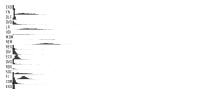

EXG (0.01122705843288523, 0.007902158250155788, 0.003405170355006694)
COM (-0.027900905215173438, 0.03330830550547664, 0.04184769113187992)
FI (0.02624202493512806, 0.11334017765420588, 0.034731023424642085)
SOC (0.21839149639107575, 0.1035559370473313, 0.06759955822456587)
RDG (0.6559108268398197, 0.04513034990696239, 0.06401552156302695)
DVG (0.25788467519334024, 0.03818118344315333, 0.08452416751543937)
ECO (0.002980300494529922, 0.04603618776088082, 0.030150763900622962)
DIV (-0.26498692413508246, 0.022064244536988607, 0.03517745945921854)
REG (0.5509744109666201, 0.047118477358357023, 0.07270980152991323)
REM (0.18155305784978892, 0.3448518831238516, 0.07193572473572277)
MDM (0.8759744068922077, 0.33243059732877434, 0.0839613589164655)
UDI (0.6440041264510207, 0.12492597148846407, 0.10335486182923426)
LR (0.15240906636373114, 0.18820906883959715, 0.08019341594795178)
DVD (0.16350740278588555, 0.048078711371903886, 0.07604212970048282)
DLF (0.1557767104076, 0.01647151261181275, 0.0

In [9]:
scores = {
    n: sum(([T1[circo][-len(NUANCES):][i]/T1[circo][EXPRIMES]]*(T1[circo][EXPRIMES]//1000) for circo in T1), [])
    for i, n in enumerate(NUANCES)
}

def compute_model():
    model = {}
    for nuance in scores:
        values = list(scores[nuance])
        l = len(values)
        z = values.count(0)
        values.sort()
        values = values[z:]
        mu, sigma = mean(values), stdev(values)
        v0 = (1+erf(-mu/sigma/sqrt(2)))/2
        model[nuance] = z/l-v0, mu, sigma
    return model

model = compute_model()

try: # are we in a module?
    __file__
except NameError:
    histograms = sg.Group(
        children=[
            sg.Group(transform=[sg.Translate(0, -5*i)], children=[
                sg.Text(n, font_size=3, x=-7, y=-1),
                histogram([s for s in scores[n] if s != 0] + [2], .01, .001)
            ])
            for i, n in enumerate(NUANCES)
        ]
    )
    display(SVG(serialize(histograms, margin=5)))

    for k in model:
        print(k, model[k])

## Premier tour
On utilise le modèle pour tirer des premiers tours.
Si un candidat n'est pas présent, son score est reporté au prorata du soutien calculés ci-dessus.
Le score par nuances influe aussi les scores des autres nuances en fonction de la corrélation calculée plus haut.

In [10]:
def first_round():
    votes = [0. for _ in NUANCES]
    # first draw some scores from the model
    for i, nuance in enumerate(NUANCES):
        _, mu, sigma = model[nuance]
        v = random.normalvariate(0, 1)
        s = max(0., (v*sigma)+mu)
        votes[i] += s
    
    # then, remove some candidates and redistribute their votes    
    to_clear = []
    to_add = [0. for _ in NUANCES]
    for i, nuance in enumerate(NUANCES):
        z, _, _ = model[nuance]
        if random.random() > z: continue
        to_clear += [i]
        v = votes[i]
        S = sum(exp(soutiens[nuance, n]-1) for n in NUANCES)
        for j, n in enumerate(NUANCES):
            if i == j: continue
            s = exp(soutiens[nuance, n]-1)
            if s < 1.: continue
            to_add[j] += v*s/S
    
    for i, nuance in enumerate(NUANCES):
        votes[i] += to_add[i]
    for i in to_clear:
        votes[i] = 0.
    
    return votes

---------------
## Tests

Pour vérifier que notre modèle fournit quelque chose de plausible, on génère des premiers tours avec le nombre de circonscriptions officielles.

Sans les corrections, si on ne regarde que le candidat arrivé en tête, on a une sous-représentation de COM, RDG, DVG, ECO, DIV, REG, MDM, DVD, (SOC et UDI dans une moindre mesure) et une sur-représentation de FI, LR et FN.
En regardant parmi les 2 finalistes, c'est un peu mieux.

Suite aux corrections, on arrive à une présence au second tour réaliste.

On corrige le modèle pour un meilleur résultat. Pour ajuster ces valeurs, on compare la proba de présence au second tour avec le second tour réel de 2017. On corrige itérativement la nuance avec le plus gros écart en ajustant la proba de présence ou la moyenne suivant la forme de la distribution réelle.

In [11]:
model = compute_model()

def correct(nuance, dz=0, dmu=0, dsigma=0.):
    z, mu, sigma = model[nuance]
    model[nuance] = z+dz, mu+dmu, sigma+dsigma

correct('REM', dmu=-.048)
correct('MDM', dmu=-.035)
correct('UDI', dmu=-.11,  dsigma=+.05)
correct('COM', dmu=-.27,  dsigma=+.17)
correct('SOC', dmu=+.003, dsigma=+.001)
correct('RDG', dmu=-.55, dsigma=+.28)
correct('DVG', dmu=-.25, dsigma=+.15)
correct('DIV', dz=+.9,   dmu=-.02,  dsigma=+.09)
correct('REG', dz=-.25, dmu=-.14, dsigma=+.06)
correct('ECO', dmu=-.07, dsigma=+.055)
correct('FI',  dmu=+.0035, dsigma=-.02)
correct('LR',  dmu=-.005)
correct('FN',  dmu=+.011, dsigma=-.03)
correct('DVD', dmu=-.1, dsigma=+.06)

In [12]:
def check(first_rounds, K=2):
    print(*("%4s" % n for n in NUANCES))
    
    o_finalists = defaultdict(int)
    o = defaultdict(int) # official
    for k in T1:
        _, _, _, _, _, _, *t1 = T1[k]
        topk = tuple(sorted(argtopk(t1, K)))
        o_finalists[topk] += 1
        for i in topk:
            o[i] += 1
    print(*("%4s" % o[i] for i, _ in enumerate(NUANCES)))

    finalists = defaultdict(int)
    for first_round in first_rounds:
        k = 10
        t1s = [
            first_round()
            for _ in range(len(T1)*k)
        ]

        s = defaultdict(int) # synthetic
        for t1 in t1s:
            topk = tuple(sorted(argtopk(t1, K)))
            finalists[topk] += 1
            for i in topk:
                s[i] += 1
#        print(*("%4.2f" % (s[i]/o[i]/k if o[i] != 0 else float('nan'),) for i in range(N)))
        print(*("%4i" % (s[i]//k,) for i, _ in enumerate(NUANCES)))
    
#    print(*(
#        (" ".join(NUANCES[u] for u in f), o_finalists[f], finalists[f]//(k*len(first_rounds))) 
#        for f in sorted(
#            o_finalists, key=lambda f: -o_finalists[f]
#        )[:10]
#    ), sep='\n')

try:
    __file__
except NameError:
    check([first_round]*5, 3)
    check([first_round]*5, 2)
#    check([first_round]*5, 1)

 EXG  COM   FI  SOC  RDG  DVG  ECO  DIV  REG  REM  MDM  UDI   LR  DVD  DLF   FN  EXD
   1   18  214  134    7   29   17   20   17  467   68   56  358   39    1  284    1
   0   21  196  129    6   35   18   24   19  462   72   54  359   41    0  287    0
   0   17  201  130    6   34   19   24   19  468   70   52  348   40    0  296    0
   0   18  204  131    6   33   21   25   18  469   63   54  353   40    0  288    0
   0   19  206  125    7   37   20   25   17  469   70   53  347   40    0  290    0
   0   19  205  132    6   36   20   24   18  461   66   52  351   38    0  294    0
 EXG  COM   FI  SOC  RDG  DVG  ECO  DIV  REG  REM  MDM  UDI   LR  DVD  DLF   FN  EXD
   0   12   67   64    5   21    3   12    9  455   61   35  266   23    1  119    1
   0   13   58   61    5   23    9   14   10  448   63   37  255   27    0  124    0
   0   13   56   61    5   21    8   12   10  455   63   37  260   23    0  123    0
   0   11   60   60    5   24    7   11    9  450   66   33  268 

---------------

## Taille des circonscriptions
### Données réelles

In [13]:
counts = [
    T1[k][EXPRIMES]
    for k in T1
]

try: # are we in a module?
    __file__
except NameError:
    display(SVG(serialize(histogram(counts, 2000, .1))))
    print(mean(counts), stdev(counts), len(counts))

39261.98266897747 9368.524617760686 577


On suppose la distribution normale.

### Génération de tailles de circonscriptions
On caractérise la distribution des tailles par sa moyenne et son écart type.
On crée une distribution aléatoire (mais reproductible) de taille de circonscritions.

In [14]:
mu, sigma = mean(counts), stdev(counts)

def generate_sizes(N):
    f = sum(counts)/N/mu
    sizes = [random.normalvariate(mu*f, sigma*f) for _ in range(N)]
    k = sum(sizes)/sum(counts)
    return [int(u/k) for u in sizes]

random.seed(13)
sizes = generate_sizes(344)

try: # are we in a module?
    __file__
except NameError:
    display(SVG(serialize(histogram(sizes, 2000, .1))))
    print(mean(sizes), stdev(sizes))

65854.61337209302 15715.227868192316


## Second tour

Pour vérifier qu'on a quelque chose de réaliste, on compare le résultat majoritaire avec l'élection réelle ($N=577$), la part majoritaire de J. Lang ($N=344$) et celle de T. Nova ($N=103$).

In [15]:
model = compute_model()

def correct(nuance, dz=0, dmu=0, dsigma=0.):
    z, mu, sigma = model[nuance]
    model[nuance] = z+dz, mu+dmu, sigma+dsigma

correct('UDI', dmu=-.09)
correct('LR',  dmu=-.036)
correct('FN',  dmu=-.03)

correct('REM', dmu=-.042)
correct('MDM', dmu=-.045)

correct('COM', dmu=+.06)
correct('FI',  dmu=+.001)
correct('SOC', dmu=+.025)

correct('DVD', dmu=+.08)
correct('DVG', dmu=-.04)
correct('RDG', dmu=+.025)
correct('REG', dmu=+.04)
correct('ECO', dmu=+.12)
correct('DIV', dmu=+.11)

In [16]:
def redistrict_abstract(N):
    circonscriptions = {}
    sizes = generate_sizes(N)
    for i, exprimes in enumerate(sizes):
        circo = "A-%i-%03i" % (N, i+1)
        t1 = first_round()
        s = sum(t1)
        t1 = [u*exprimes/s for u in t1]
        circonscriptions[circo] = {
            "t1": [exprimes, 0, 0, 0, 0, exprimes] + t1
        }
    return circonscriptions

---------
## Tests

In [17]:
def check(K=10):
    from data.HandCraftedMaps import SCENARIO_103_TN, SCENARIO_344_JL

    totals = {}
    for scenario in [SCENARIO_103_TN, SCENARIO_344_JL]:
        total = [0. for _ in NUANCES]
        for k in scenario:
            total = [t+s for t, s in zip(total, scenario[k]["votes"])]
        totals[int(sum(total))] = total
    totals[sum(RESULTATS_OFFICIELS)] = RESULTATS_OFFICIELS

    from rules.PluralityRunoff import nb_elected
    from rules.PluralityRunoff import plurality_with_runoff as rule
    from predictors.LinearPredictor import linear_predictor as predictor
    
    from vis.Graphs import representativity_graph_polar

    for N in [103, 344, 577]:
        sizes = generate_sizes(N)
        electeds = defaultdict(list)
        for j in range(K):
            circonscriptions = redistrict_abstract(N)
            t2, winners = rule(circonscriptions, predictor)
            elected = [e for e in nb_elected(winners)]
            for n, d in zip(NUANCES, elected):
                electeds[n] += [d]
        print(N, "---------")
        for n, o in zip(electeds, totals[N]):
            l = electeds[n]
            diffs = [d-o for d in l]
            diffs.sort()
            d = mean(l)
            s = stdev(l)
            print("%3s %5.1f ±%5.1f /%4i (%+4d %+4d)" % (n, d, s, o, d-o, diffs[len(diffs)//2]))
        
#        votes = [
#            sum(circonscriptions[circo]['t1'][i] for circo in circonscriptions)
#            for i in range(6, 6+len(NUANCES))
#        ]
#        display(
#            SVG(serialize(representativity_graph_polar(elected, votes), margin=100))
#        )

try:
    __file__
except NameError:
    check(100)

103 ---------
EXG   0.0 ±  0.0 /   0 (  +0   +0)
COM   1.8 ±  1.4 /   0 (  +1   +1)
 FI   2.1 ±  1.5 /   1 (  +1   +1)
SOC   4.4 ±  2.1 /   3 (  +1   +2)
RDG   0.3 ±  0.5 /   0 (  +0   +0)
DVG   0.8 ±  0.9 /   2 (  -1   -1)
ECO   0.1 ±  0.3 /   0 (  +0   +0)
DIV   0.0 ±  0.1 /   0 (  +0   +0)
REG   0.4 ±  0.6 /   1 (  +0   -1)
REM  60.2 ±  5.2 /  79 ( -18  -19)
MDM   8.1 ±  2.4 /   0 (  +8   +8)
UDI   1.8 ±  1.4 /   0 (  +1   +2)
 LR  19.5 ±  4.1 /  15 (  +4   +5)
DVD   0.7 ±  0.8 /   0 (  +0   +0)
DLF   0.0 ±  0.0 /   0 (  +0   +0)
 FN   2.8 ±  1.8 /   1 (  +1   +2)
EXD   0.0 ±  0.0 /   0 (  +0   +0)
344 ---------
EXG   0.0 ±  0.0 /   0 (  +0   +0)
COM   6.9 ±  2.6 /   5 (  +1   +1)
 FI   7.8 ±  2.8 /   6 (  +1   +1)
SOC  16.8 ±  4.4 /  20 (  -3   -4)
RDG   1.2 ±  1.0 /   1 (  +0   +0)
DVG   5.0 ±  2.3 /   3 (  +1   +1)
ECO   0.9 ±  0.9 /   0 (  +0   +1)
DIV   0.0 ±  0.2 /   0 (  +0   +0)
REG   2.0 ±  1.4 /   1 (  +1   +1)
REM 192.5 ± 10.1 / 228 ( -35  -35)
MDM  26.0 ±  5.5 /   0 ( +2